In [ ]:

!pip install lifelines
!pip install scanpy[louvain]

     |████████████████████████████████| 389kB 9.7MB/s 
     |████████████████████████████████| 1.9MB 8.6MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 3.6MB 48.1MB/s 
     |████████████████████████████████| 13.0MB 181kB/s 
     |████████████████████████████████| 378kB 43.6MB/s 
     |████████████████████████████████| 92kB 12.4MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.7.1.post6-cp36-cp36m-linux_x86_64.whl size=2221674 sha256=837f2b5aada7eb06909aa7d4db7c23cca504db82a906f471d5ae4f14e49df79e
  Stored in directory: /root/.cache/pip/wheels/41/d6/02/34eebae97e25f5b87d60f4c0687e00523e3f244fa41bc3f4a7
  Created wheel for louvain: filename=louvain-0.6.1-cp36-cp36m-linux_x86_64.whl size=1027918 sha256=633d58e1fffeaca91ff6d21facc98e90b546906c36ba265520f6c1518b144b08
  Stored in directory: /root/.cache/pip/wheels/f2/c3/d4/f7abaf064186d6214ef952bbb72fd6c5136d4b17dbeaeff481
Successfully built python-igraph louvain
ERROR: alb

In [ ]:


from google.colab import drive

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Tumor mutation burden and nivolumab response

Data files=:

[bms038_clinical_data.csv](https://drive.google.com/open?id=1IeWfXJ5AjIGITNPsI_yrvQIDxhg7pBSv)

[pre_therapy_nonsynonmous_mutations.csv](https://drive.google.com/file/d/1ZVX170ZkJ_WVtUJgheQlzAi-qZoylDvG/view?usp=sharing)

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
DATA = Path("/content/drive/My Drive/2019 ECBM E4060/data/2019-11-11")

clin_file = DATA / "bms038_clinical_data.csv"
mutation_data = DATA/"pre_therapy_nonsynonmous_mutations.csv"
clin = pd.read_csv(clin_file)
mut = pd.read_csv(mutation_data)
# convert the patient id and sample name to lower case
clin['PatientID'] = clin['PatientID'].str.lower()
clin['Sample'] = clin['Sample'].str.lower()
mut['Patient'] = mut['Patient'].str.lower()
clin.head()


,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3
0,pt1,pt1_pre,pre,NIV3-PROG,NaN,NIV3-PROG,PD,PD,0,0,160,22.857143,PROGRESSION,54,7.714286,PD,SDPD
1,pt10,pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD
2,pt100,pt100_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PD,PD,0,0,840,120.000000,PROGRESSION,50,7.142857,PD,SDPD
3,pt101,pt101_pre,pre,NIV3-PROG,TripleWt,NIV3-PROG,PR,PRCR,0,1,834,119.142857,PARTIAL RESPONSE,612,87.428571,PRCRSD,PRCR
4,pt102,pt102_pre,pre,NIV3-NAIVE,RAS,NIV3-NAIVE,SD,SD,0,1,636,90.857143,STABLE DISEASE,112,16.000000,PRCRSD,SDPD


In [ ]:
mut.head()

,Patient,Hugo Symbol,Chromosome,Start,End,Variant Classification,HGVS_c,HGVS_p,Tcov,Tac,Taf
0,pt10,MST1L,1,17083776,17083776,missense_variant,c.2021G>T,p.Arg674Leu,232,10,0.043103
1,pt10,MST1L,1,17083816,17083816,stop_gained,c.1981C>T,p.Arg661*,316,13,0.041139
2,pt10,NRAS,1,115258748,115258748,missense_variant,c.34G>T,p.Gly12Cys,576,491,0.852431
3,pt10,DCST2,1,154997000,154997000,missense_variant,c.1690C>T,p.Arg564Trp,340,37,0.108824
4,pt10,PAPPA2,1,176525744,176525744,missense_variant,c.286A>C,p.Lys96Gln,664,53,0.079819


In [ ]:
overlap_patients = set(clin.PatientID) & set(mut.Patient) 

mut = mut.loc[mut.Patient.isin(overlap_patients),:]
clin = clin.loc[clin.PatientID.isin(overlap_patients),:]

In [ ]:
tmb = mut.groupby("Patient")["Hugo Symbol"].count().reset_index()
tmb.max()


Patient        pt98
Hugo Symbol    7360
dtype: object

In [ ]:
tmb.min()

Patient        pt10
Hugo Symbol       1
dtype: object

In [ ]:
tmb.median()

Hugo Symbol    182.5
dtype: float64

In [ ]:
tmb.head()

,Patient,Hugo Symbol
0,pt10,75
1,pt100,6
2,pt101,10
3,pt102,393
4,pt103,21


In [ ]:
tmb.rename(columns = {'Patient':'PatientID'}, inplace = True) 
tmb.rename(columns = {'Hugo Symbol':'mutation_load'}, inplace = True) 
tmb = pd.merge(tmb, clin.loc[:, ["PatientID", "BOR"]], on="PatientID")
tmb['log_mutation_load'] = np.log10(tmb.mutation_load)
tmb.head()

,PatientID,mutation_load,BOR,log_mutation_load
0,pt10,75,SD,1.875061
1,pt100,6,PD,0.778151
2,pt101,10,PR,1.000000
3,pt102,393,SD,2.594393
4,pt103,21,PD,1.322219


Text(0, 0.5, 'log(mutation load)')

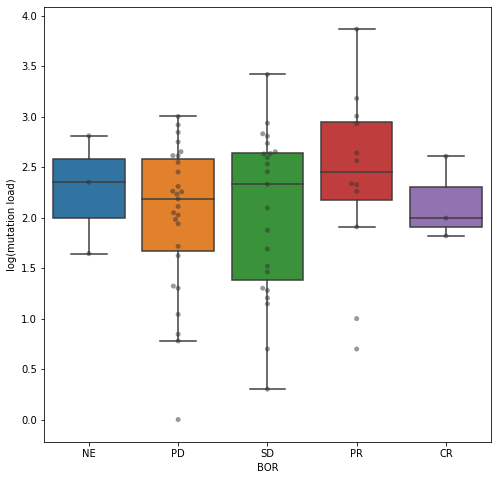

In [ ]:
import seaborn as sns
import numpy as np

# get response data by merge it with clinical data


fig, axarr = plt.subplots()
fig.set_size_inches(8, 8)

sns.boxplot(x="BOR", y="log_mutation_load", data=tmb, order=["NE", "PD", "SD", "PR", "CR"], fliersize=0, ax=axarr)
sns.swarmplot(x="BOR", y="log_mutation_load", data=tmb, order=["NE", "PD", "SD", "PR", "CR"], color=".2", alpha=0.5, ax=axarr)
axarr.set_ylabel("log(mutation load)")
# sns.boxplot(x="BOR", y="CD274", data=pd1, order=["NE", "PD", "SD", "PR", "CR"], fliersize=0, ax=axarr[1])
# sns.swarmplot(x="BOR", y="CD274", data=pd1, order=["NE", "PD", "SD", "PR", "CR"], color=".2", alpha=0.5, ax=axarr[1])
# axarr[1].set_ylabel("PD-L1 mRNA Expression")


In [ ]:
from scipy.stats import mannwhitneyu

mannwhitneyu(tmb.loc[tmb.BOR.isin(["PD", "SD"]), "mutation_load"],
             tmb.loc[tmb.BOR.isin(["PR", "CR"]), "mutation_load"])


MannwhitneyuResult(statistic=298.5, pvalue=0.11833637016018267)

## Tumor mutation burden and overall survival in Ipilimumab-Naive patients


In [ ]:
no_iptreatment = clin.loc[clin['Cohort'] == 'NIV3-NAIVE']
no_iptreatment.head()


#============================================================================
# Your code here
# Create a subset of clinical data and mutation data containing only patients
# who have never received ipilimumab (Cohort == NIV3-NAIVE)
#============================================================================

,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3
1,pt10,pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD
4,pt102,pt102_pre,pre,NIV3-NAIVE,RAS,NIV3-NAIVE,SD,SD,0,1,636,90.857143,STABLE DISEASE,112,16.000000,PRCRSD,SDPD
9,pt11,pt11_pre,pre,NIV3-NAIVE,BRAF,NIV3-NAIVE,PD,PD,0,0,837,119.571429,PROGRESSION,59,8.428571,PD,SDPD
10,pt13,pt13_pre,pre,NIV3-NAIVE,BRAF,NIV3-NAIVE,PD,PD,0,0,280,40.000000,PROGRESSION,62,8.857143,PD,SDPD
12,pt18,pt18_pre,pre,NIV3-NAIVE,BRAF,NIV3-NAIVE,PR,PRCR,0,1,1073,153.285714,NaN,519,74.142857,PRCRSD,PRCR


In [ ]:
from lifelines import CoxPHFitter

mat = no_iptreatment[["PatientID", "OS", "OS_SOR"]].copy()
# mat["os_event"] = mat["OS_SOR"]
mat["os_event"] = 1 - mat["OS_SOR"]
mat.drop("OS_SOR", axis=1, inplace=True)
# mat.set_index("PatientID", inplace=True)
mat.head()


,PatientID,OS,os_event
1,pt10,256,1
4,pt102,636,0
9,pt11,837,1
10,pt13,280,1
12,pt18,1073,0


In [ ]:
lp_list = list(no_iptreatment["PatientID"])
tmb_lp = tmb.loc[tmb['PatientID'].isin(lp_list)]

In [ ]:
mat_tmb = pd.merge(mat, tmb_lp.loc[:, ["PatientID", "log_mutation_load"]], on="PatientID")
mat_tmb.set_index("PatientID", inplace=True)
mat_tmb
cph = CoxPHFitter()
cph.fit(mat_tmb, duration_col='OS', event_col='os_event')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
log_mutation_load,-0.62363,0.535995,0.381198,-1.370765,0.123505,0.253913,1.131456,-1.635971,0.101846,3.295545


In [ ]:
mat_tmb.head()

,OS,os_event,log_mutation_load
PatientID,,,
pt10,256,1,1.875061
pt102,636,0,2.594393
pt11,837,1,2.025306
pt13,280,1,2.232996
pt18,1073,0,2.336460


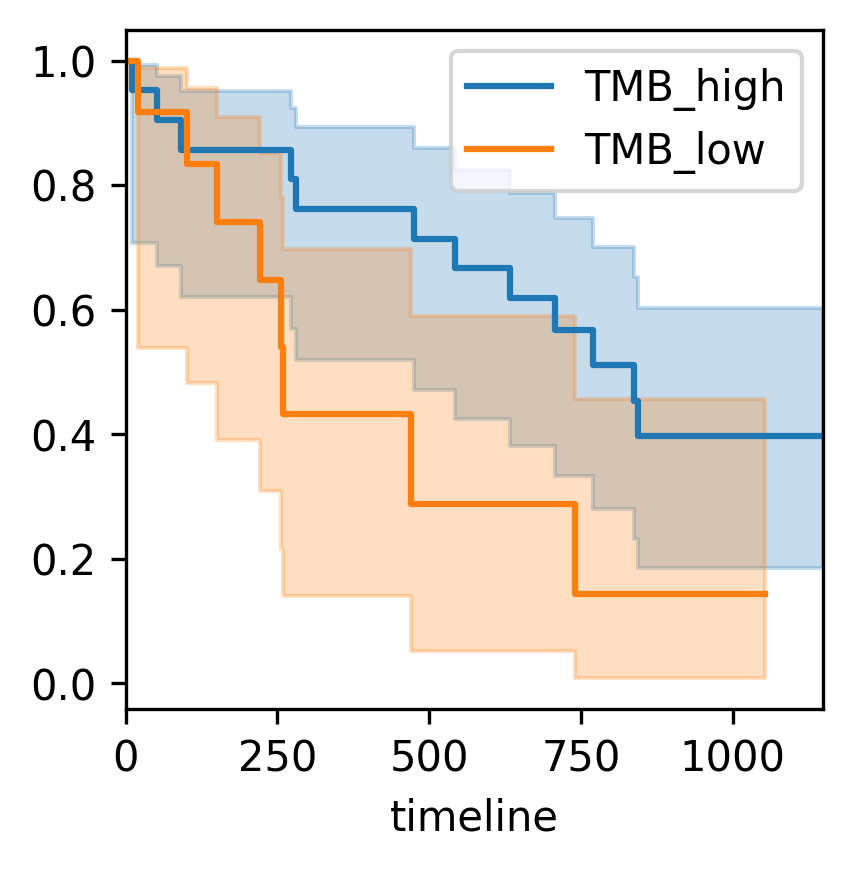

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(dpi=300, figsize=(3, 3))

tmb_high_idx = mat_tmb.log_mutation_load >= 2

kmf.fit(mat_tmb.OS[tmb_high_idx], mat_tmb.os_event[tmb_high_idx],
        label="TMB_high")
kmf.plot(ax=ax)
kmf.fit(mat_tmb.OS[~tmb_high_idx], mat_tmb.os_event[~tmb_high_idx],
        label="TMB_low")
kmf.plot(ax=ax)

## : single cell clustering in tumor samples
 Data: [GSE72056](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056).

* [skcm_gse72056_scrna_tpm.txt.gz](https://drive.google.com/file/d/1CzErlSBAxLAYxbG0It06OgOwQnKlBLVV/view?usp=sharing) : Expression data

* [skcm_gse72056_scrna_meta.txt](https://drive.google.com/file/d/1efum9Dr3FSv5UAPV5VOi5m0NpIyFzEw7/view?usp=sharing) : Sample meta data

In [ ]:

import pandas as pd
from pathlib import Path
import scanpy as sc

# set scanpy plotting parameter to dpi = 150
sc.settings.set_figure_params(dpi=150)

DATA = Path("/content/drive/My Drive/2019 ECBM E4060/data/hw4")

In [ ]:
ge = sc.read_csv(DATA / "skcm_gse72056_scrna_tpm.txt.gz",
                 delimiter="\t").transpose()
meta = pd.read_csv(DATA / "skcm_gse72056_scrna_meta.txt", sep="\t",
                   index_col=0)

# to prevent some issues later, we rename the tumor columns with prefix 't'
meta["tumor"] = "t" + meta.tumor.astype(str)

ge.shape

(4645, 23684)

In [ ]:
ge.var_names

Index(['C9orf152', 'RPS11', 'ELMO2', 'CREB3L1', 'PNMA1', 'MMP2', 'TMEM216',
       'TRAF3IP2-AS1', 'LRRC37A5P', 'LOC653712',
       ...
       'GPLD1', 'SNORD115-39', 'RAB8A', 'RXFP2', 'PCIF1', 'PIK3IP1', 'SNRPD2',
       'SLC39A6', 'CTSC', 'AQP7'],
      dtype='object', length=23684)

In [ ]:
ge.obs = pd.concat([ge.obs, meta.loc[ge.obs_names]], axis=1, sort=False)

ge.obs.head()

,tumor,cell_type_annot_by_author
Cy72_CD45_H02_S758_comb,t72,B
CY58_1_CD45_B02_S974_comb,t58,T
Cy71_CD45_D08_S524_comb,t71,malignant
Cy81_FNA_CD45_B01_S301_comb,t81,malignant
Cy80_II_CD45_B07_S883_comb,t80,malignant


In [ ]:
ge_cancer = ge[(ge.obs.cell_type_annot_by_author == "malignant"), :]
ge_immune = ge[(ge.obs.cell_type_annot_by_author != "malignant"), :]

In [ ]:
ge_cancer

View of AnnData object with n_obs × n_vars = 1758 × 23684 
    obs: 'tumor', 'cell_type_annot_by_author'

In [ ]:
ge_immune

View of AnnData object with n_obs × n_vars = 2887 × 23684 
    obs: 'tumor', 'cell_type_annot_by_author'

In [ ]:
sc.pp.scale(ge_cancer, max_value=10)
sc.tl.pca(ge_cancer, svd_solver='arpack')
sc.pp.neighbors(ge_cancer, n_neighbors=15, n_pcs=25)
sc.tl.umap(ge_cancer)
sc.tl.louvain(ge_cancer)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... storing 'tumor' as categorical
... storing 'cell_type_annot_by_author' as categorical


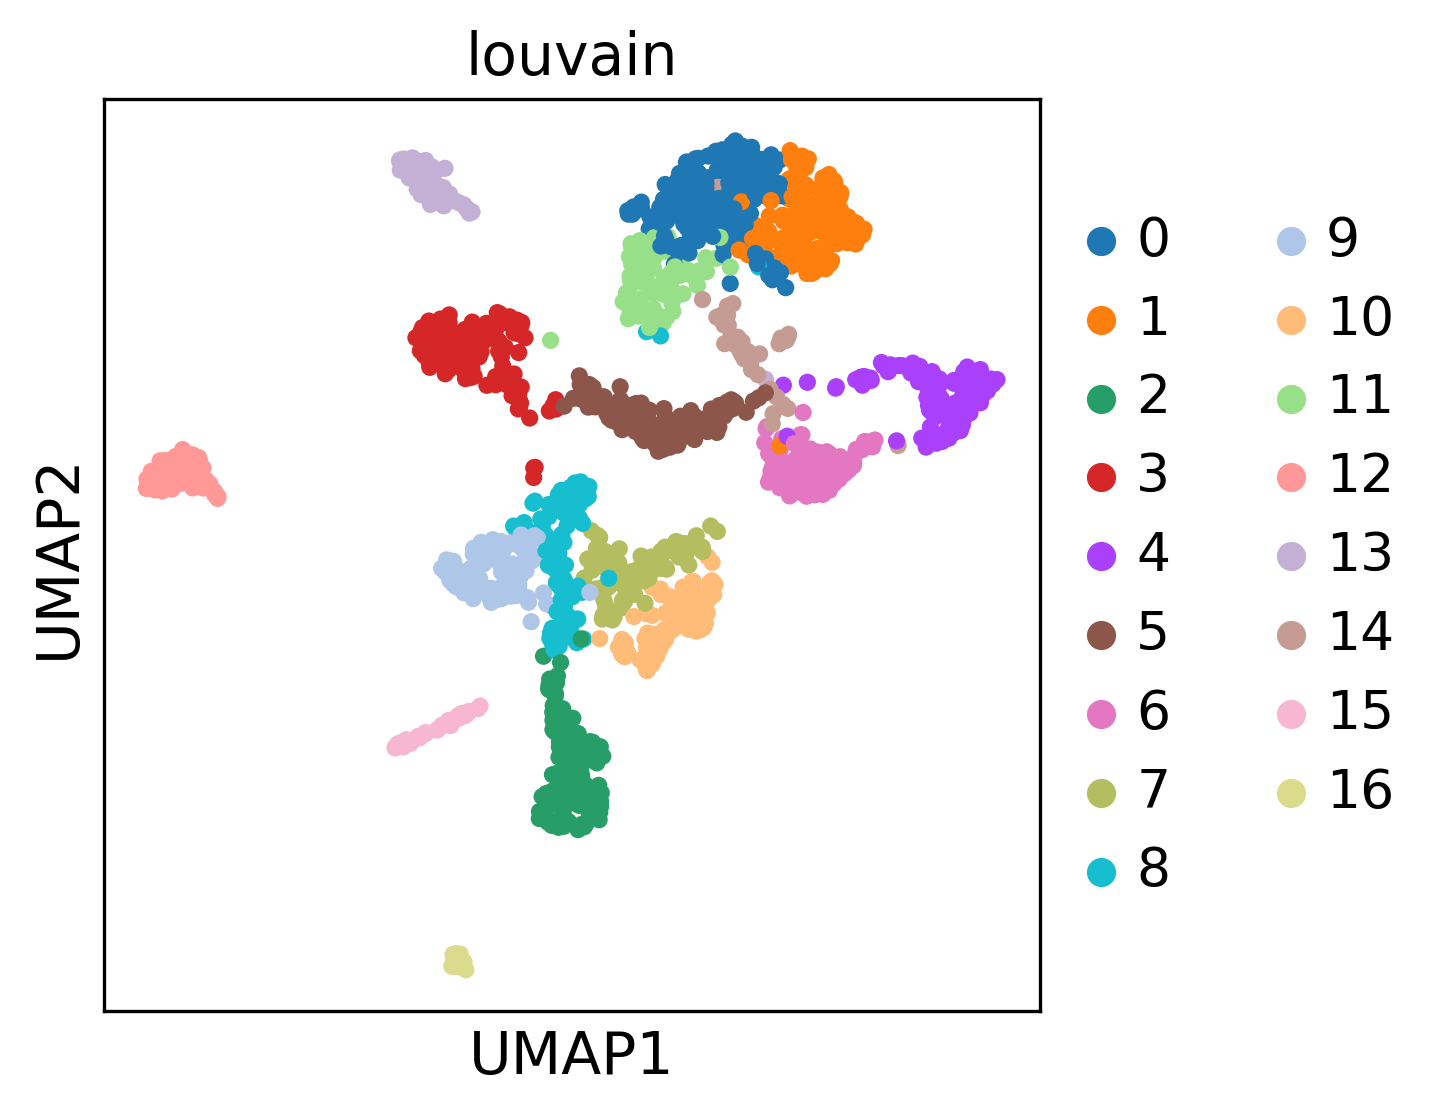

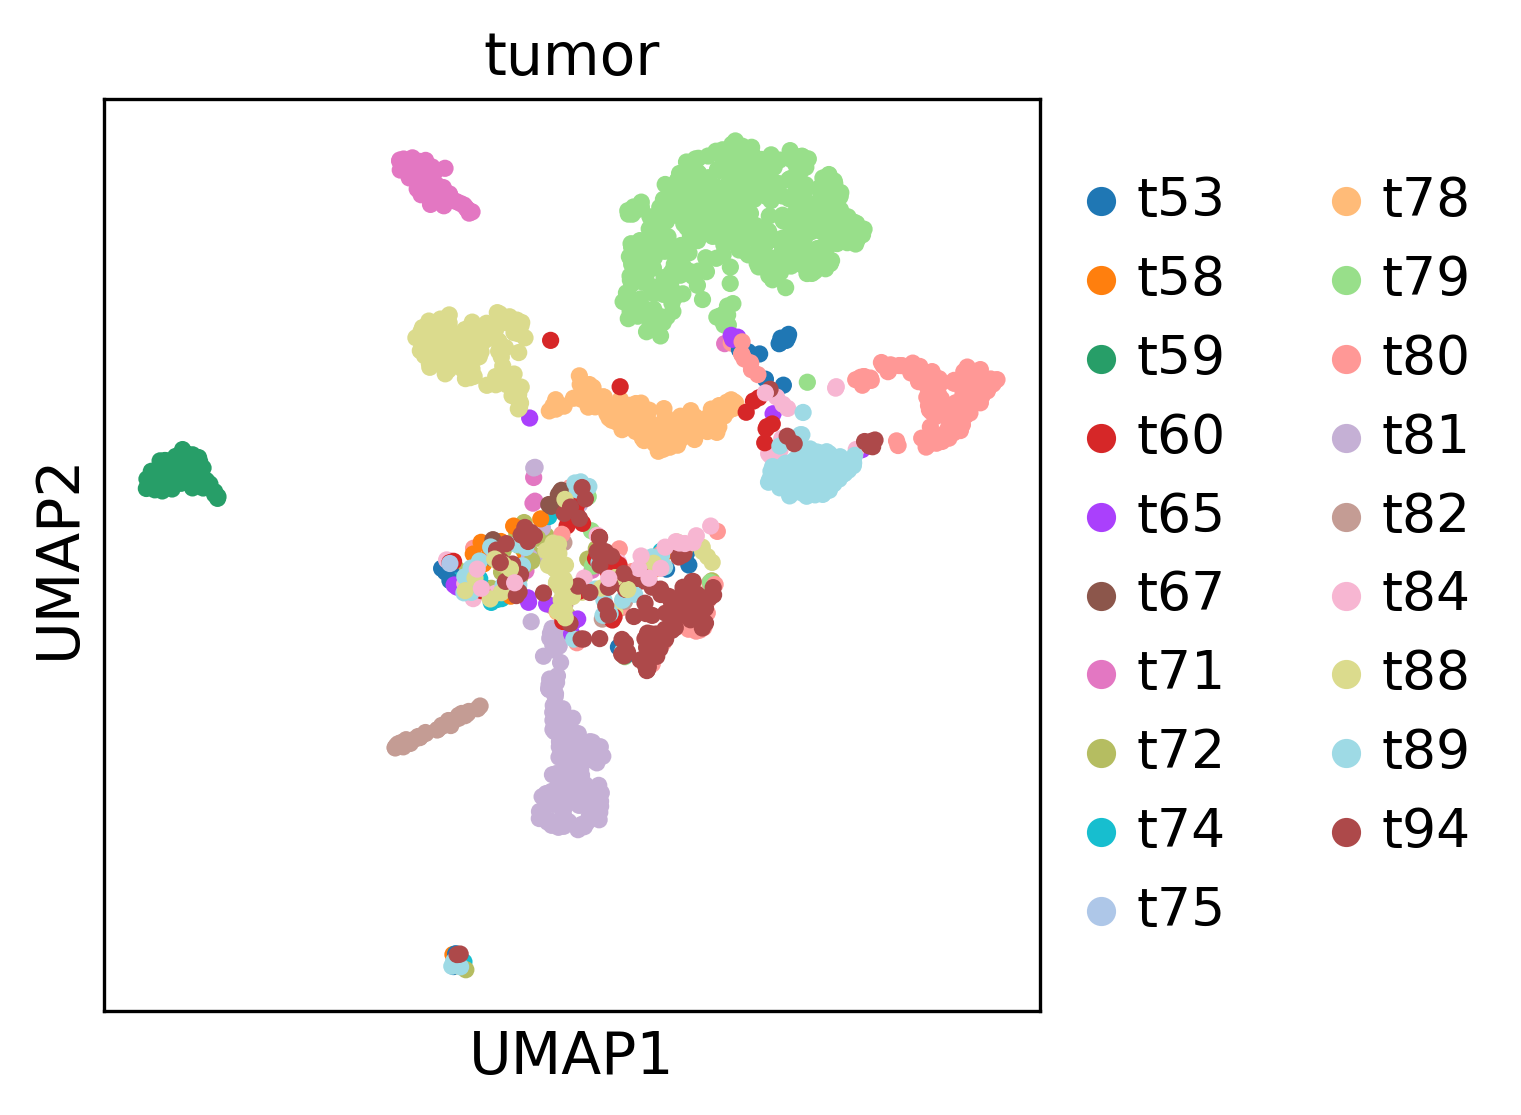

In [ ]:
sc.pl.umap(ge_cancer, color = ["louvain"])
sc.pl.umap(ge_cancer, color = ["tumor"])

17 clusters from louvain. Some cancer cells are separated by tumor source, but not all of them are well separated based on tumor source. 



---

### Perform louvain clustering and UMAP visualization on immune cells


In [ ]:
sc.pp.scale(ge_immune, max_value=10)
sc.tl.pca(ge_immune, svd_solver='arpack')
sc.pp.neighbors(ge_immune, n_neighbors=15, n_pcs=25)
sc.tl.umap(ge_immune)
sc.tl.louvain(ge_immune)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


... storing 'tumor' as categorical
... storing 'cell_type_annot_by_author' as categorical


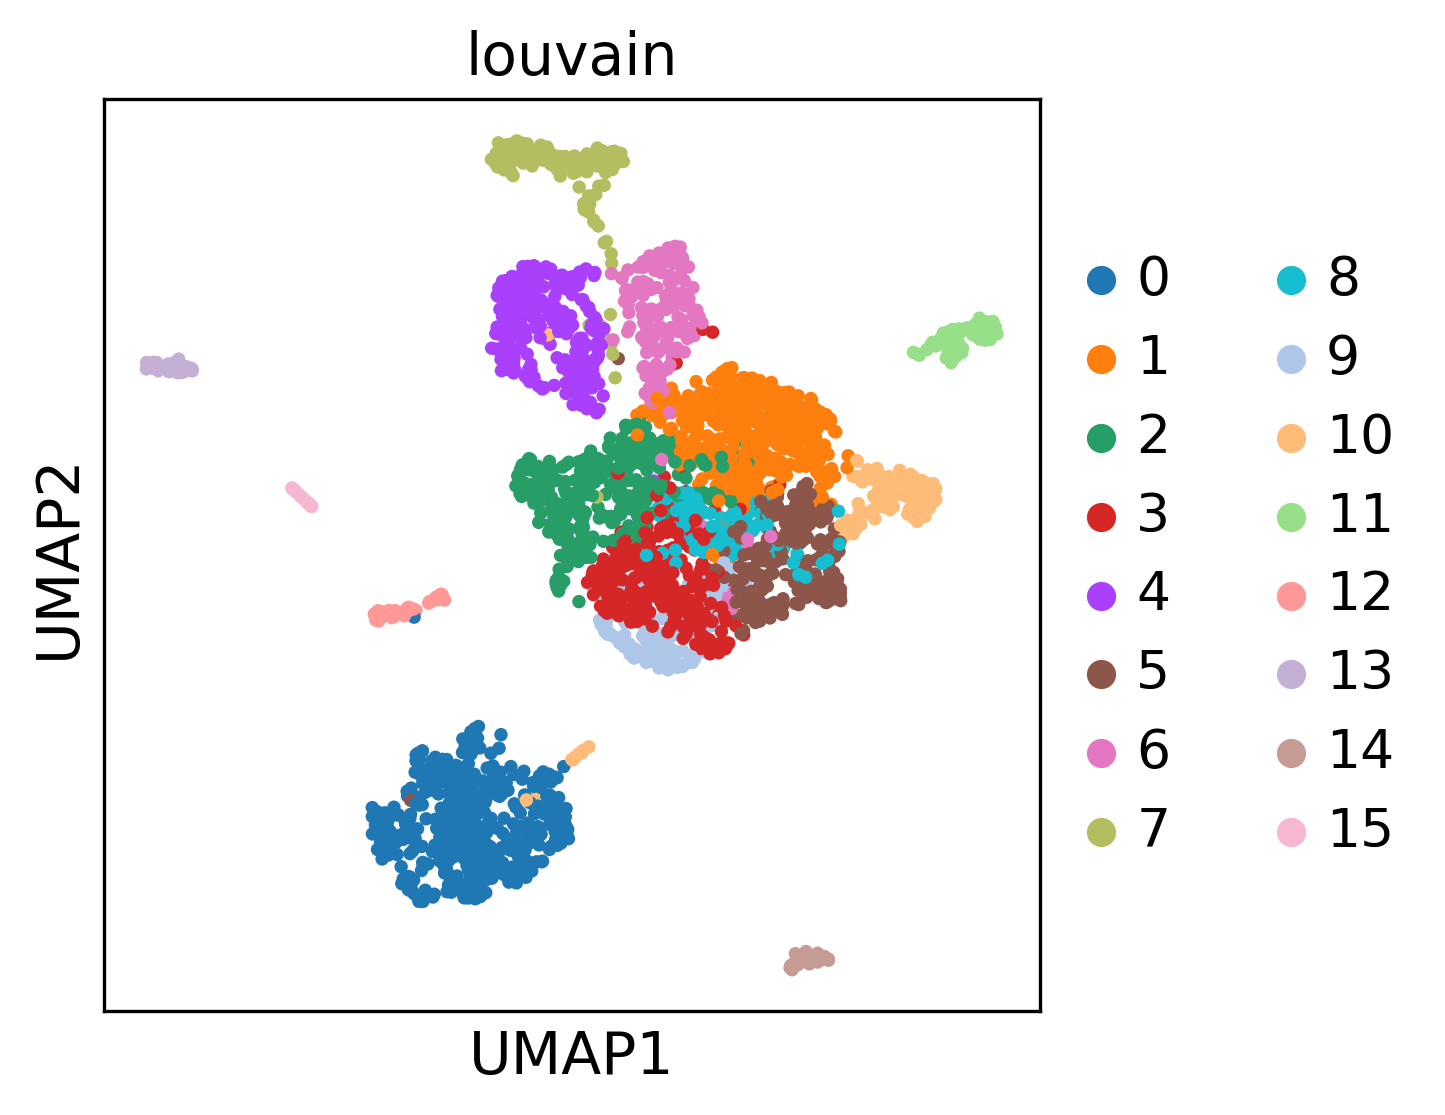

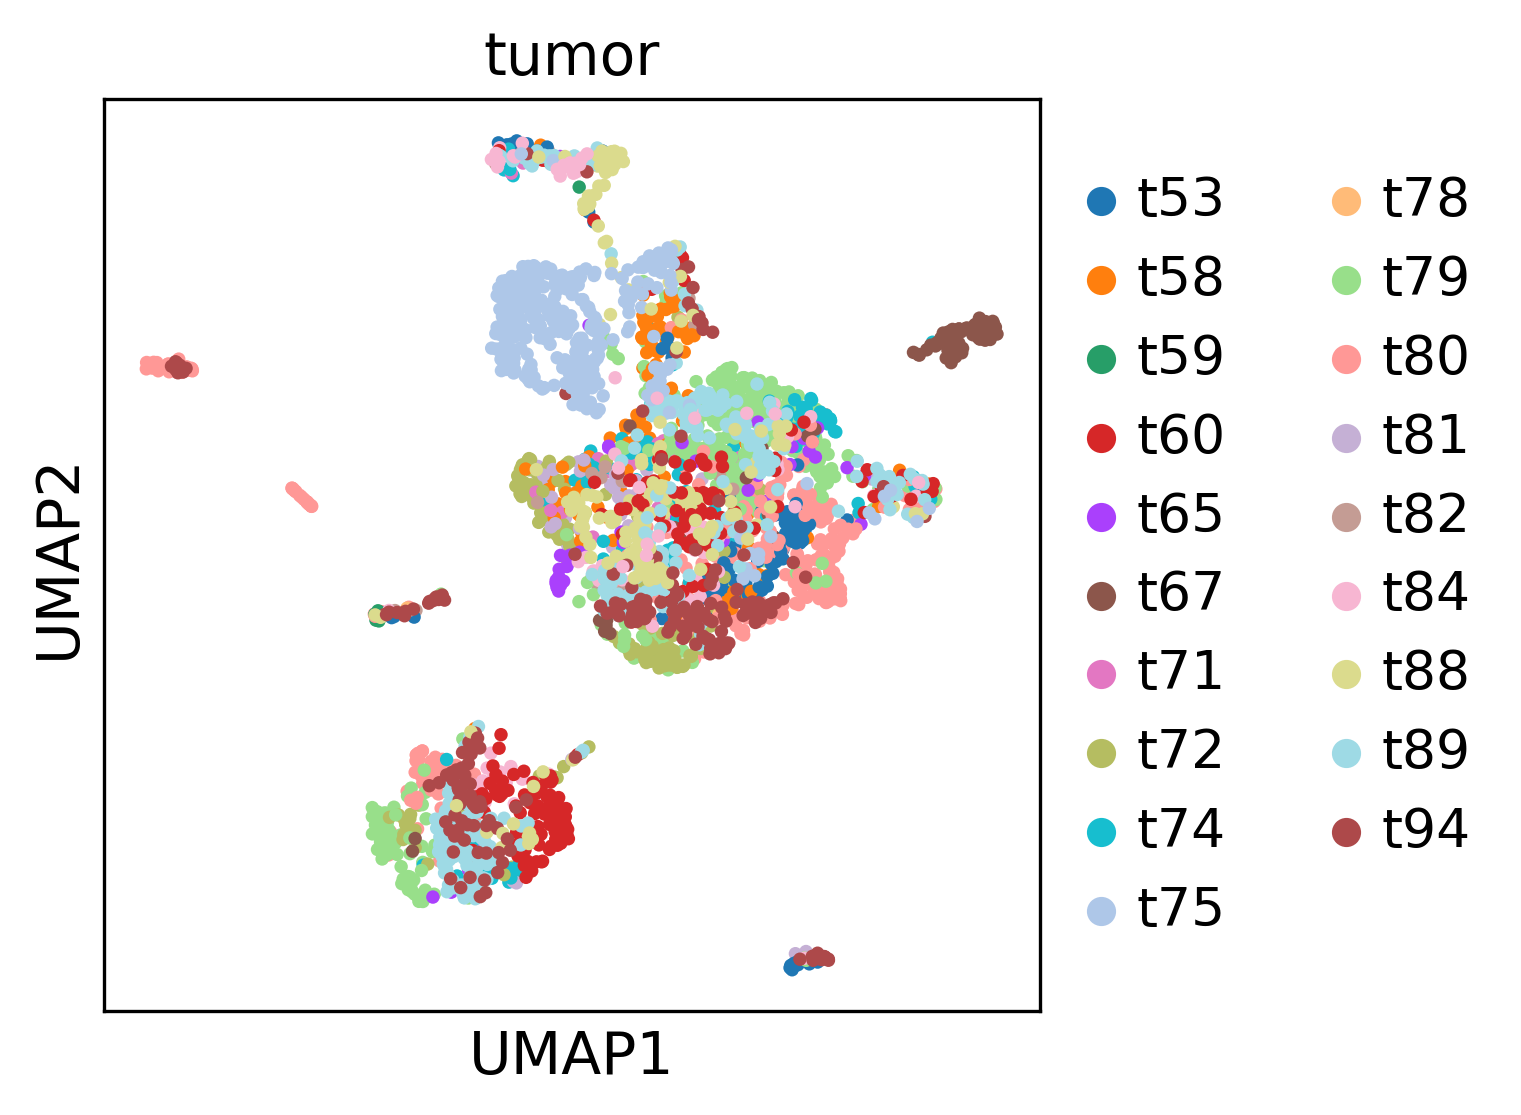

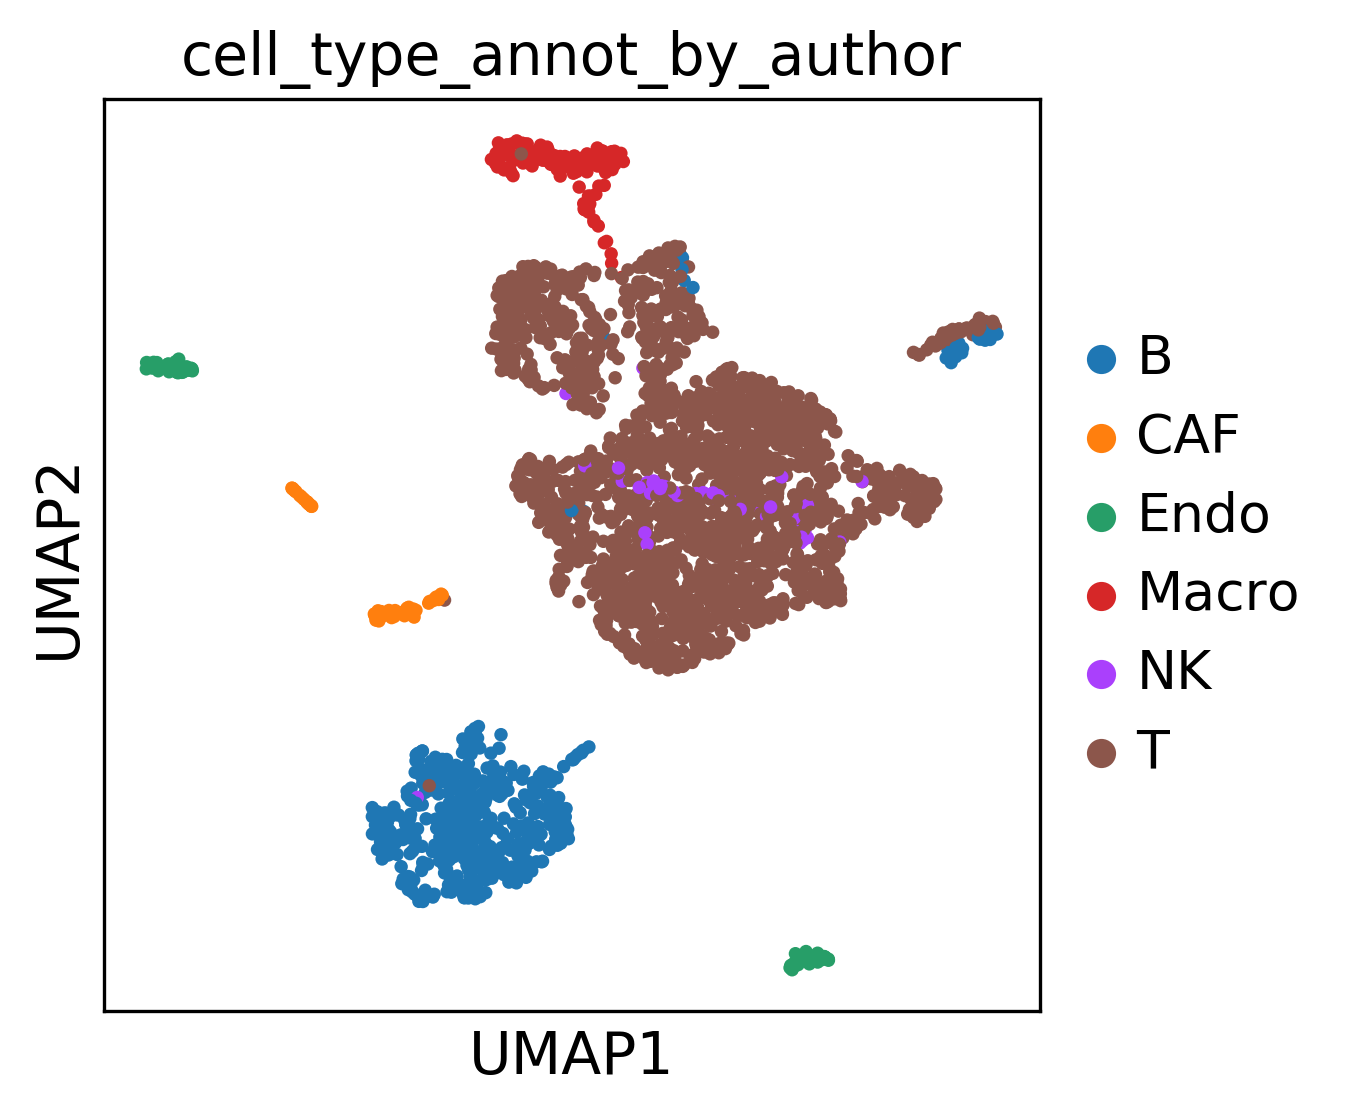

In [ ]:
sc.pl.umap(ge_immune, color = ["louvain"])
sc.pl.umap(ge_immune, color = ["tumor"])
sc.pl.umap(ge_immune, color = ["cell_type_annot_by_author"])

In [ ]:
import pandas as pd
sc.tl.rank_genes_groups(ge_immune, 'louvain', method='t-test')

... storing 'tumor' as categorical
... storing 'cell_type_annot_by_author' as categorical
/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:223: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


In [ ]:
pd.DataFrame(ge_immune.uns['rank_genes_groups']['names']).head(25)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,CD79A,CD8A,HNRNPH1,IL7R,CD8A,ZAP70,TMEM212,CST3,CD3D,RPS12,GAPDH,LOC646214,C1S,IGFBP7,IFITM3,CALU
1,MS4A1,CD3D,C1orf56,TCF7,NKG7,XIST,LOC643406,PSAP,IL32,TPT1,HMGN2,SHISA9,SERPING1,TFPI,ENG,ANXA2
2,HLA-DRA,CST7,B2M,TPT1,KLRK1,CD3E,LOC646214,TYROBP,CD4,JUNB,HMGB1,UGDH-AS1,VIM,IFITM3,A2M,TPM4
3,CD74,HLA-A,RPL41,FYB,CCL5,ARHGDIB,SHISA9,S100A11,CD2,RPL32,TUBA1B,ABCC9,SPARC,HYAL2,SPARC,PTRF
4,HLA-DPA1,CBLB,RPS27,RPL10,FCRL3,CORO1A,LRTOMT,AIF1,SPOCK2,RPLP2,STMN1,TMEM212,PCOLCE,CNN3,PLVAP,ANXA5
5,BANK1,HLA-C,TMSB4X,RPL9,LYST,IFITM1,L2HGDH,FCER1G,TIGIT,RPS16,DEK,ORC4,TIMP1,ANXA2,APP,DSTN
6,CD79B,CD2,TMSB10,RPS3,HSPA1A,HLA-A,LOC100131257,FTL,MAF,IL7R,H2AFZ,LOC643406,COL3A1,PDLIM1,AQP1,CD59
7,HLA-DRB1,NKG7,RPS25,RPS12,SLAMF7,IL32,PDDC1,CTSB,MYL6,RPL31,TUBB,HERC2P4,CALD1,SDPR,VIM,CNN3
8,IRF8,CCL5,RPL34,EEF1A1,MAP1LC3C,ITGAL,LOC286437,FTH1,PBXIP1,RPL19,TPI1,ODF2L,COL1A2,FABP5,VWF,LMNA
9,HLA-DPB1,KLRK1,BCL11B,RPS3A,GBP5,ITGB2,ORC4,CD68,SUMO2,RPS25,RAN,KCNQ1OT1,LUM,TIMP3,IGFBP7,KDELR2


## Inter tumor heterogeneity vs intra tumor heterogeneity




In [ ]:
from scipy import stats
ge_mitf = ge_cancer[:,ge_cancer.var_names == "MITF"]
cor_mitf = []
for i in range(0,len(ge_cancer.var_names)):
  rho, pval = stats.spearmanr(ge_mitf.X,ge_cancer[:,i].X)
  cor_mitf.append([ge_cancer.var_names[i],rho])

/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib

In [ ]:
cor_mitf = pd.DataFrame(cor_mitf,columns =['gene','correlation']) 
mitf10 = cor_mitf.nlargest(10, ['correlation']) 
mitf10list = list(mitf10['gene'])
mitf10list

['MITF',
 'PMEL',
 'MLANA',
 'GPNMB',
 'GPR143',
 'ASAH1',
 'TYR',
 'MLPH',
 'SDCBP',
 'TFAP2A']

Next, perform the same calculation with AXL. Identify the top 10 genes with highest positive Spearman correlation with AXL.

In [ ]:
ge_axl = ge_cancer[:,ge_cancer.var_names == "AXL"]
cor_axl = []
for i in range(0,len(ge_cancer.var_names)):
  rho, pval = stats.spearmanr(ge_axl.X,ge_cancer[:,i].X)
  cor_axl.append([ge_cancer.var_names[i],rho])


/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib

In [ ]:
cor_axl = pd.DataFrame(cor_axl,columns =['gene','correlation']) 
axl10 = cor_axl.nlargest(10, ['correlation']) 
axl10list = list(axl10['gene'])
axl10list

['AXL',
 'CCL5',
 'ZNF793',
 'PRICKLE2-AS3',
 'FBLIM1',
 'TNFAIP8L1',
 'LOC90834',
 'SLFNL1-AS1',
 'LAIR1',
 'TLCD2']

With the two co-expressed gene sets defined. we can calculate the `MITF_geneset` expression for each cell as the mean expression of the 10 MITF-correlated genes, and the `AXL_geneset` expression for each cell as the mean expression of the 10 AXL-correlated genes.

In [ ]:
# mitf10var = pd.DataFrame(mitf10exp.X, columns = mitf10exp.var_names)
# mitf10obs = pd.DataFrame(mitf10exp.obs)
# mitf10expave['mean'] = mitf10expave.mean(axis = 1)
# axl10expave = pd.DataFrame(axl10exp.X, columns = axl10exp.var_names)
# axl10expave['mean'] = axl10expave.mean(axis = 1)

In [ ]:
test = pd.DataFrame(mitf10exp.obs)
test.reset_index(level=0, inplace=True)
test

NameError: ignored

In [ ]:
pd.DataFrame(mitf10exp.X)
pd.concat([test, test2], axis = 1)

,index,tumor,cell_type_annot_by_author,louvain,0
0,Cy71_CD45_D08_S524_comb,t71,malignant,13,0.888241
1,Cy81_FNA_CD45_B01_S301_comb,t81,malignant,2,-0.610170
2,Cy80_II_CD45_B07_S883_comb,t80,malignant,4,0.512173
3,Cy81_Bulk_CD45_B10_S118_comb,t81,malignant,2,-0.328065
4,Cy71_CD45_B05_S497_comb,t71,malignant,13,0.563211
...,...,...,...,...,...
1753,CY84_PRIM_POS_All_8_A01_S97_comb,t84,malignant,7,-0.605760
1754,CY84_PRIM_POS_All_8_E11_S155_comb,t84,malignant,8,-1.276453
1755,CY94_CD45NEG_CD90POS_2_D08_S44_comb,t94,malignant,10,-0.988883
1756,CY84_PRIM_POS_All_7_A01_S193_comb,t84,malignant,7,-0.577861


In [ ]:
mitf10exp = ge_cancer[:, ge_cancer.var_names.isin(mitf10list)]
# mitf_geneset = pd.DataFrame(mitf10exp.X)
mitf_geneset = pd.DataFrame(mitf10exp.X.mean(axis=1))
mitf_geneset.columns = ['MITF']
# mitf_geneset = pd.DataFrame(mitf_geneset)
# mitf_geneset.set_index(mitf10exp.obs_names)

axl10exp = ge_cancer[:, ge_cancer.var_names.isin(axl10list)]
axl_geneset = pd.DataFrame(axl10exp.X.mean(axis=1))
axl_geneset.columns = ['AXL']


In [ ]:

final_set = pd.DataFrame(mitf10exp.obs)
final_set.reset_index(level=0, inplace=True)
final_set = pd.concat([final_set, mitf_geneset], axis = 1)
final_set = pd.concat([final_set, axl_geneset], axis = 1)
# final_set.drop('index', axis=1, inplace=True)
# final_set.drop(['index','louvain','cell_type_annot_by_author'], axis=1, inplace = True)




In [ ]:
final_set

,index,tumor,cell_type_annot_by_author,louvain,MITF,AXL
0,Cy71_CD45_D08_S524_comb,t71,malignant,13,0.888241,-0.283678
1,Cy81_FNA_CD45_B01_S301_comb,t81,malignant,2,-0.610170,0.056430
2,Cy80_II_CD45_B07_S883_comb,t80,malignant,4,0.512173,-0.789724
3,Cy81_Bulk_CD45_B10_S118_comb,t81,malignant,2,-0.328065,-0.070753
4,Cy71_CD45_B05_S497_comb,t71,malignant,13,0.563211,0.060032
...,...,...,...,...,...,...
1753,CY84_PRIM_POS_All_8_A01_S97_comb,t84,malignant,7,-0.605760,0.996876
1754,CY84_PRIM_POS_All_8_E11_S155_comb,t84,malignant,8,-1.276453,0.398812
1755,CY94_CD45NEG_CD90POS_2_D08_S44_comb,t94,malignant,10,-0.988883,0.369258
1756,CY84_PRIM_POS_All_7_A01_S193_comb,t84,malignant,7,-0.577861,0.776943


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


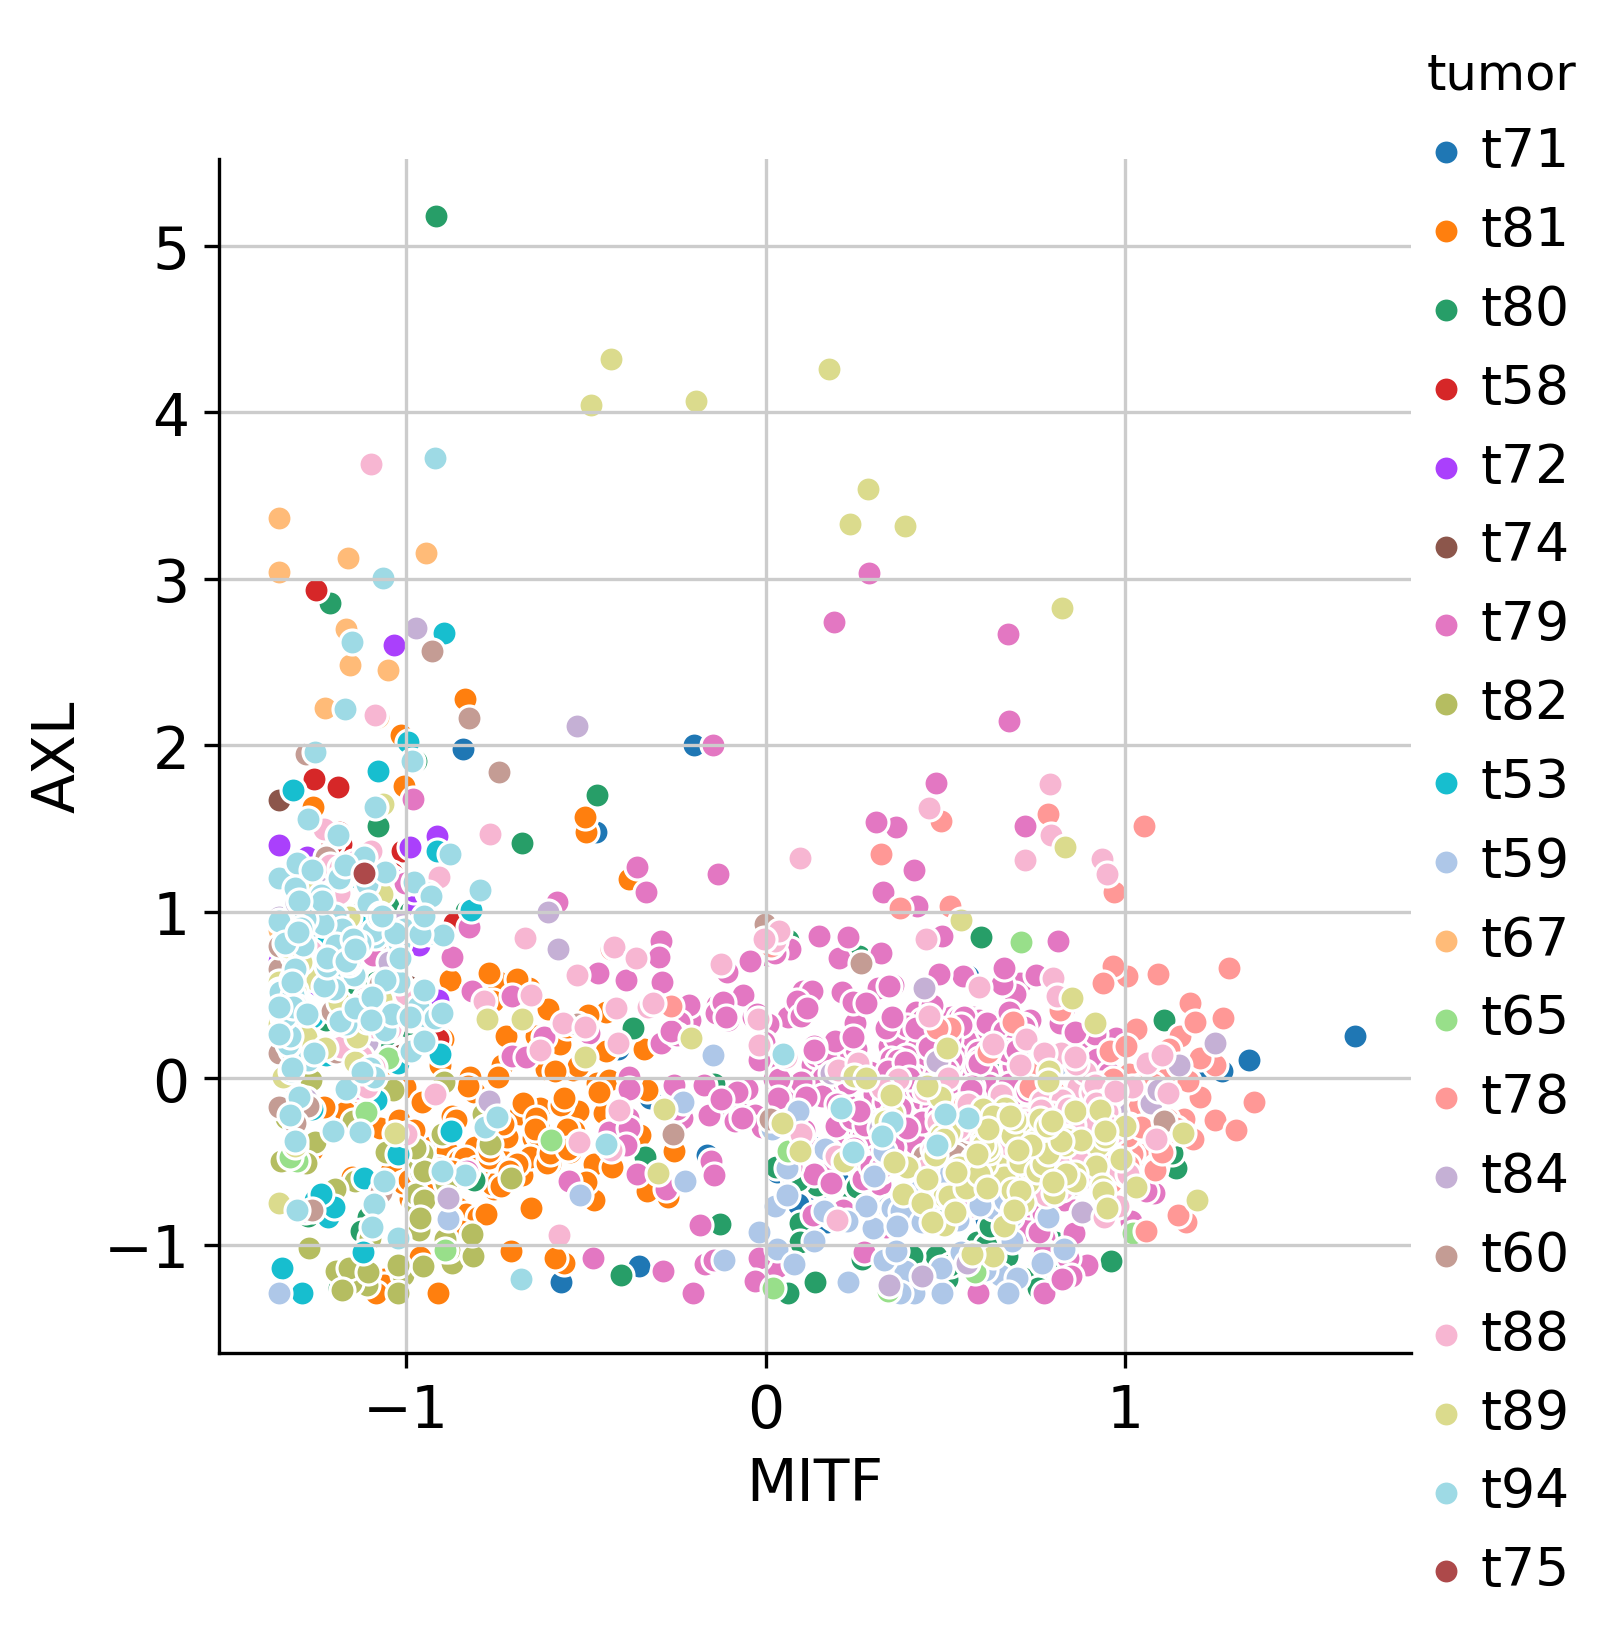

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# x = final_set['MITF']
# y = final_set['AXL']
# plt.xlabel('MITF')
# plt.ylabel('AXL')
sns.pairplot(x_vars=['MITF'], y_vars=['AXL'], data=final_set, hue="tumor", size=5)
# plt.scatter(x,y, c = final_set['tumor'].unique())


In [ ]:
tumor_level = final_set.groupby("tumor").mean()
tumor_level.reset_index(level=0, inplace=True)
tumor_level


,tumor,MITF,AXL
0,t53,-1.132506,0.372824
1,t58,-1.145507,1.239309
2,t59,0.315790,-0.812997
3,t60,-0.646617,0.324093
4,t65,-0.309610,-0.458078
5,t67,-1.183127,2.559999
6,t71,0.411331,-0.241811
7,t72,-1.131167,0.817998
8,t74,-1.246716,0.540626
9,t75,-1.116572,1.231801


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


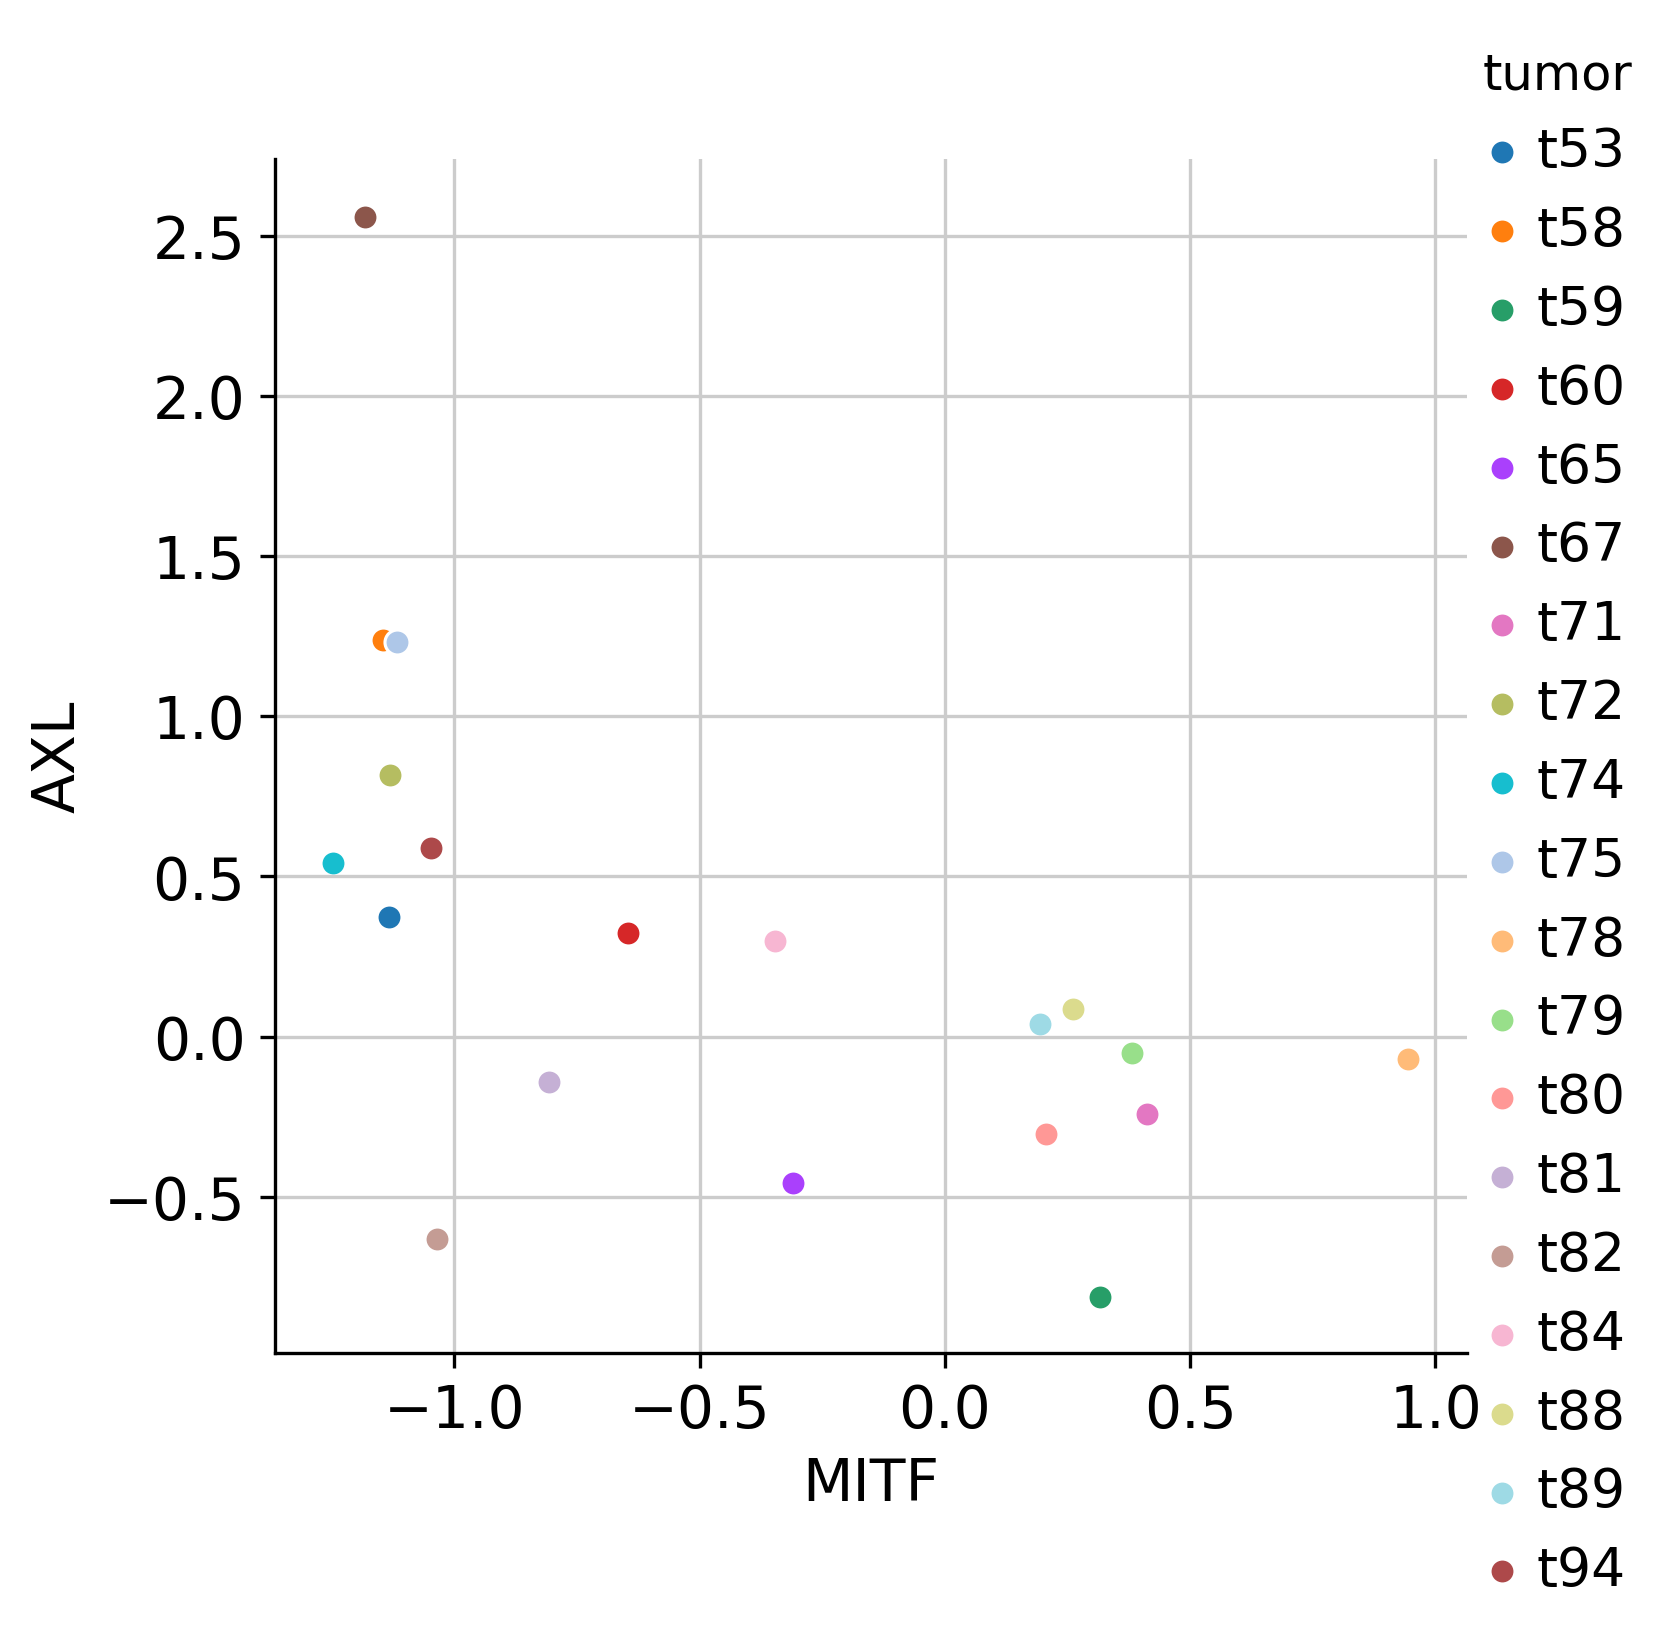

In [ ]:
sns.pairplot(x_vars=['MITF'], y_vars=['AXL'], data=tumor_level, hue="tumor", size=5)

Similarly, do a scatter plot showing on one axis the MITF geneset expression, and AXL geneset expression on the other axis. Now each dot is a tumor. Color the dots by `tumor` id.